In [117]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (14, 7), 'axes.grid': False,
             'lines.markersize': 6, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

In [118]:
def RHS(t, y):
    """Calculate the RHS of the EoM, as described above.
    Parameters:
        y: array. Vector of length 24 holding the current position and velocity of the three objects 
           in the following manner: 
           y = [x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4
                vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4].
    Returns:
        z: array. Vector of length 24 holding the derivative of the current position and velocity 
           (the velocity and acceleration) of the three object in the following manner:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4].
    """
    
    # Allocate a vector to hold the output values
    z = np.zeros(24)
    # Define initial velocities and distances between objects
    z[:12] = [y[i] for i in range(12, 24)]
    
    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    a1 = G * (m2 * (r2 - r1) / r21 ** 3 + m3 * (r3 - r1) / r31 ** 3 + m4 * (r4 - r1) / r41 ** 3)
    a2 = G * (m1 * (r1 - r2) / r21 ** 3 + m3 * (r3 - r2) / r32 ** 3 + m4 * (r4 - r2) / r42 ** 3)
    a3 = G * (m1 * (r1 - r3) / r31 ** 3 + m2 * (r2 - r3) / r32 ** 3 + m4 * (r4 - r3) / r43 ** 3)
    a4 = G * (m1 * (r1 - r4) / r41 ** 3 + m2 * (r2 - r4) / r42 ** 3 + m3 * (r3 - r4) / r43 ** 3)

    z[12:15] = a1
    z[15:18] = a2
    z[18:21] = a3
    z[21:24] = a4

    return z

In [119]:
def energy(z):
    """Calculate the mechanical energies of the three body system.
    Parameters:
        z: array. Vector of length 24 holding the current position and velocity of the three objects in the
           following manner:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4]
    Returns:
        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.
    """

    r1, r2, r3, r4 = [z[i: i + 3] for i in range(0, 12, 3)]
    # Pairwise distance between objects
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G * m1 * m2 / r21
    U3 = -G * m1 * m3 / r31 - G * m3 * m2 / r32
    U4 = -G * m4 * m1 / r41 - G * m4 * m2 / r42 - G * m4 * m3 / r43
    U = U1 + U2 + U3 + U4
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5 * m1 * np.linalg.norm(z[12:15]) ** 2
    K2 = 0.5 * m1 * np.linalg.norm(z[15:18]) ** 2
    K3 = 0.5 * m1 * np.linalg.norm(z[18:21]) ** 2
    K4 = 0.5 * m1 * np.linalg.norm(z[21:24]) ** 2
    K = K1 + K2 + K3 + K4
    
    return U, K

In [121]:
def distanceToStars(y):
    """Calculate absolute angular momentum of the three body system.
    Parameters:
        y:          array. Vector of length 24 holding the current position and velocity of the three objects
                    in the following manner: 
                    y = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4
                        ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4].
    Returns:
        r21, r31, r41: array. Distance of the first object(planet) to the other objects(stars).
    """
    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    # Pairwise distance between objects
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)

    return [r21, r31, r41]

In [122]:
def ode45(f,t,y,h):
    """Calculate next step of an initial value problem (IVP) of an ODE with a RHS described
    by the RHS function with an order 4 approx. and an order 5 approx.
    Parameters:
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    
    s1 = f(t, y)
    s2 = f(t + h / 4.0, y + h * s1 / 4.0)
    s3 = f(t + 3.0 * h / 8.0, y + 3.0 * h * s1 / 32.0 + 9.0 * h * s2 / 32.0)
    s4 = f(t + 12.0 * h / 13.0, y + 1932.0 * h * s1 / 2197.0 - 7200.0 * h * s2 / 2197.0 + 7296.0 * h * s3 / 2197.0)
    s5 = f(t + h, y + 439.0 * h * s1 / 216.0 - 8.0 * h * s2 + 3680.0 * h * s3 / 513.0 - 845.0 * h * s4 / 4104.0)
    s6 = f(t + h / 2.0, y - 8.0 * h * s1 / 27.0 + 2 * h * s2 - 3544.0 * h * s3 / 2565 + 1859.0 * h * s4 / 4104.0 - 11.0 * h * s5 / 40.0)
    w = y + h * (25.0 * s1 / 216.0 + 1408.0 * s3 / 2565.0 + 2197.0 * s4 / 4104.0 - s5 / 5.0)
    q = y + h * (16.0 * s1 / 135.0 + 6656.0 * s3 / 12825.0 + 28561.0 * s4 / 56430.0 - 9.0 * s5 / 50.0 + 2.0 * s6 / 55.0)
    
    return w, q

In [123]:
# Set gravitaional constant and masses.
# The gravitaional constant is set to 1 for simplicity.
G = 1.
m1 = 1.
m2 = 1.
m3 = 1.
m4 = 1.

# Period of calculations
T = 10
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 4000
# "Protector-constant" for small w
theta = 0.001

# Different initial conditions to try out, on the form
# y = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
# z0 = [2., 2., 0., 0., -2., -2., 0.2, -0.2, 0., 0., -0.2, 0.2]
# z0 = [-0.970, 0.243, 0.970, -0.243, 0., 0., -0.466, -0.433, -0.466, -0.433, 2*0.466, 2*0.433]
# z0 = [1., 0.000001, -1., 0., 0., 0., 0., -0.4, 0., 0.4, 0., 0.]
z0 = np.array([2., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., -2., 0.1, 0., 0., 0.2, 0., 0., 0.3, 0., 0., 0.4, 0, 0]) # modified 4-body

In [124]:
# First step and initial time
h = T / maxi
t = 0.

# Allocate matrices and fill with initial conditions
Z = np.zeros((24, maxi + 1))
Z[:, 0] = z0
E = np.zeros((maxi + 1, 2))
E[0, :] = energy(z0)
D = np.zeros((maxi + 1, 3))
D[0, :] = distanceToStars(z0)

# Declare iteration integer
i = 0
e = 1.
# Perform ode45 calculations
tic = time.time()
while (t < T) & (i < maxi):
    w, q = ode45(RHS, t, Z[:, i], h)
    e = max(abs((w - q) / np.maximum(w, theta)))
    if e > TOL:
        h = 0.95 * (TOL * e) ** (1 / 5) * h 
        w, q = ode45(RHS, t, q, h)
        e = max(abs((w - q) / np.maximum(w, theta)))
        while e > TOL:
            h = h/2.
            w, q = ode45(RHS, t, q, h)
            e = max(abs((w - q) / np.maximum(w, theta)))
    if e < 0.1 * TOL:
        h = h * 2.
    Z[:, i + 1] = q
    E[i + 1, :] = energy(Z[:, i + 1])
    D[i + 1, :] = distanceToStars(Z[:, i + 1])
    t += h
    i += 1

print("%.5f s, run time of adaptive RK45 method." % (time.time() - tic))
    
# Print number of steps used
if (i == maxi):
    print('%i, maximum number of steps reached by adaptive RK45 method.' % i)
else:
    print('%i, steps used by adaptive RK45 method.' % i)

2.69549 s, run time of adaptive RK45 method.
1762, steps used by adaptive RK45 method.


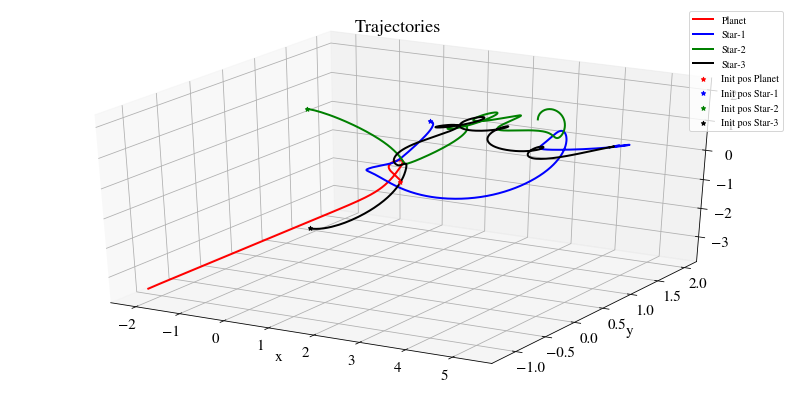

In [125]:
# Plot Trajectories
plt.figure()
ax = plt.axes(projection="3d")
plt.plot(Z[0, 0:i], Z[1, 0:i], Z[2, 0:i], '-r', label='Planet')
plt.plot(Z[3, 0:i], Z[4, 0:i], Z[5, 0:i], '-b', label='Star-1')
plt.plot(Z[6, 0:i], Z[7, 0:i], Z[8, 0:i], '-g', label='Star-2')
plt.plot(Z[9, 0:i], Z[10, 0:i], Z[11, 0:i], color='black', label='Star-3')
ax.scatter3D(Z[0, 0], Z[1, 0], Z[2, 0], marker='*', color='red', label='Init pos Planet')
ax.scatter3D(Z[3, 0], Z[4, 0], Z[5, 0], marker='*', color='blue', label='Init pos Star-1')
ax.scatter3D(Z[6, 0], Z[7, 0], Z[8, 0], marker='*', color='green', label='Init pos Star-2')
ax.scatter3D(Z[9, 0], Z[10, 0], Z[11, 0], marker='*', color='black', label='Init pos Star-3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', prop={'size': 10})
plt.title('Trajectories')
plt.show()

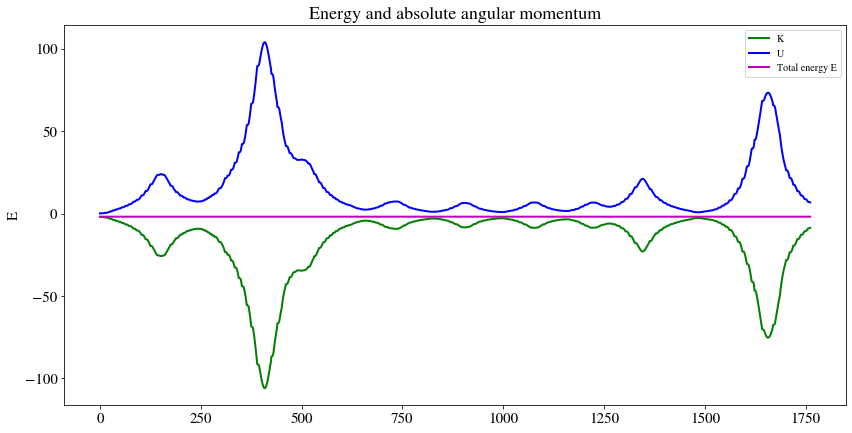

In [126]:
# Mechanical energy
plt.figure()
plt.plot(E[0:i, 0], 'g', label='K')
plt.plot(E[0:i, 1], 'b', label='U')
plt.plot(E[0:i, 0] + E[0:i ,1], 'm', label='Total energy E')
plt.ylabel('E')
plt.legend(loc='best', prop={'size': 10})
plt.title('Energy and absolute angular momentum')
plt.show()

In [127]:


# # Angular momentum
# plt.subplot(2, 2, 4)
# plt.plot(L[0:i, 0], 'r', label='L_Planet')
# plt.plot(L[0:i, 1], 'b', label='L_Star-1')
# plt.plot(L[0:i, 2], 'g', label='L_Star-2')
# plt.plot(L[0:i, 3], color='yellow', label='L_Star3')
# plt.plot(L[0:i, 0] + L[0:i, 1] + L[0:i, 2] + L[0:i, 3], 'm', label='L_total')
# plt.xlabel('Steps, i')
# plt.ylabel('L')
# plt.legend(loc='best', prop={'size': 10})
# plt.show()


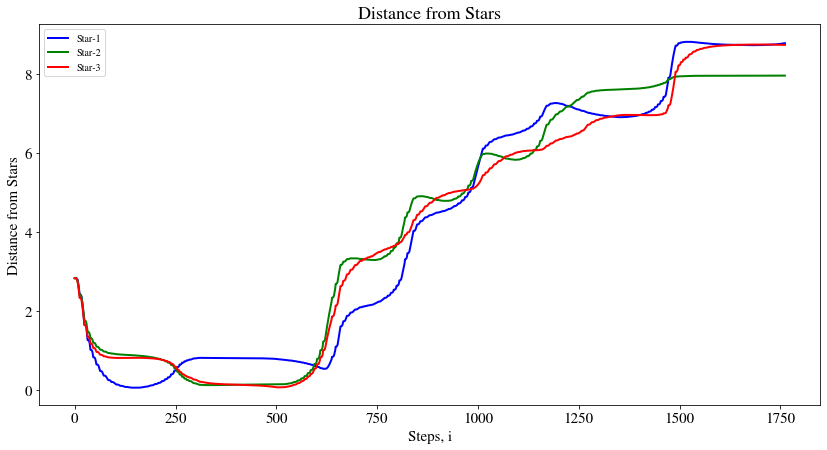

In [128]:
# Distance from Stars
plt.figure()
plt.plot(D[0:i, 0], 'b', label='Star-1')
plt.plot(D[0:i, 1], 'g', label='Star-2')
plt.plot(D[0:i, 2], 'r', label='Star-3')
plt.xlabel('Steps, i')
plt.ylabel('Distance from Stars')
plt.legend(loc='best', prop={'size': 10})
plt.title('Distance from Stars')
plt.show()

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-134-b48c8eb711d0>", line 23, in animate
    obj1.set_data(Z[0,i],Z[1,i],Z[2,i])
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/lines.py", line 659, in set_data
    x, y = args
ValueError: t

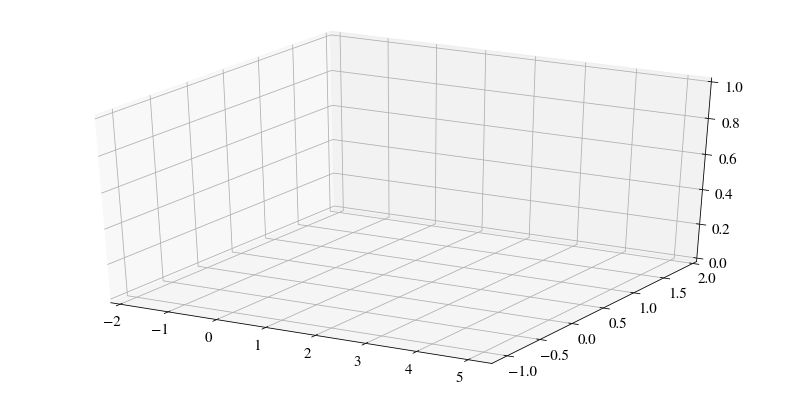

In [134]:
# Set up the figure
fig = plt.figure()
ax = plt.axes(projection="3d", xlim=(np.min(Z[[0,3,6,9],:]), np.max(Z[[0,3,6,9],:])), 
              ylim=(np.min(Z[[1,4,7,10],:]), np.max(Z[[1,4,7,10],:])))

# Define the different elements in the animation
tail1, = ax.plot([],[],[],'r') # Tail obj. 1
tail2, = ax.plot([],[],[],'b') # Tail obj. 2
tail3, = ax.plot([],[],[],'g') # Tail obj. 3
tail4, = ax.plot([],[],[],color='black') # Tail obj. 4
obj1, = ax.plot([],[],[],'ro') # Obj. 1
obj2, = ax.plot([],[],[],'bo') # Obj. 2
obj3, = ax.plot([],[],[],'go') # Obj. 3
obj4, = ax.plot([],[],[],color='black') # Obj. 4

# Calculates the number of frames
FPS = 15
framesNum = int(FPS*T)

# Animation function. This is called sequentially.
def animate(j):
    i = j*int(maxi/framesNum)
    obj1.set_data(Z[0,i],Z[1,i],Z[2,i])
    obj2.set_data(Z[3,i],Z[4,i],Z[5,i])
    obj3.set_data(Z[6,i],Z[7,i],Z[8,i])
    obj4.set_data(Z[9,i],Z[10,i],Z[11,i])
    tail1.set_data(Z[0,0:i],Z[1,0:i],Z[2,0:i])
    tail2.set_data(Z[3,0:i],Z[4,0:i],Z[5,0:i])
    tail3.set_data(Z[6,0:i],Z[7,0:i],Z[8,0:i])
    tail4.set_data(Z[9,0:i],Z[10,0:i],Z[11,0:i])

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=framesNum)

# Save animation
# If this don't work for you, try using the another writer (ffmpeg, mencoder, imagemagick),
# or another file extension (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you have
# the codec and the writer installed on your system.
# anim.save('TrisolarianTrial1.gif', writer='imagemagick', fps=FPS)

# # Close plot
# plt.close(anim._fig)

# # Display the animation
# with open('TrisolarianTrial1.gif','rb') as file:
#     display(Image(file.read()))
